In [1]:
import numpy as np
import pandas as pd
from numpy import pi
import qiskit
from qiskit import execute, Aer
from qiskit.visualization import plot_histogram
from qiskit.tools.visualization import plot_state_city, plot_bloch_multivector
from qiskit.tools.monitor import job_monitor
from qiskit.quantum_info import state_fidelity
from qiskit.quantum_info import DensityMatrix
from qiskit.quantum_info.random.utils import random_state
import random
from qiskit.providers.aer import noise
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit, Aer
%config InlineBackend.figure_format = 'svg' # Makes the images look nice

# Tomography functions
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
import qiskit.ignis.mitigation.measurement as mc
# imports IBMQ backends
from qiskit.providers.ibmq import IBMQ
from qiskit.providers.aqt import AQT
aqt_provider_simulators = AQT.enable_account('2633b2d14dae4d9da7c9df2503857334')
ibmq_provider = IBMQ.load_account()        # credentials stored on disk
simulator = ibmq_provider.get_backend('ibmq_qasm_simulator')
device = ibmq_provider.get_backend('ibmq_16_melbourne') #ibmq_burlington ibmq_16_melbourne
aqt_device = aqt_provider_simulators.get_backend('aqt_qasm_simulator_noise_1')
backend_IBMQ = ibmq_provider.get_backend('ibmqx2')
properties = backend_IBMQ.properties()
noise_model = noise.device.basic_device_noise_model(properties)
coupling_map = backend_IBMQ.configuration().coupling_map
basis_gates = noise_model.basis_gates

C:\Users\Niels\Envs\dev_qiskit\lib\site-packages\qiskit\providers\aer\noise\device\basic_device_model.py:112: DeprecationWarning: This function is been deprecated and moved to a method of the`NoiseModel` class. For equivalent functionality use `NoiseModel.from_backend(properties, **kwargs).
  DeprecationWarning)


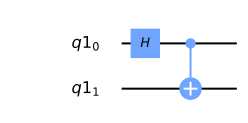

In [2]:
qreg = QuantumRegister(4)
qreg_exp = QuantumRegister(2)
qc_expected = QuantumCircuit(qreg_exp)
qc_expected.h(0)
qc_expected.cx(0,1)
qc_expected.draw(output='mpl')

The expected state is: [0.70710678+0.j 0.        +0.j 0.        +0.j 0.70710678+0.j]


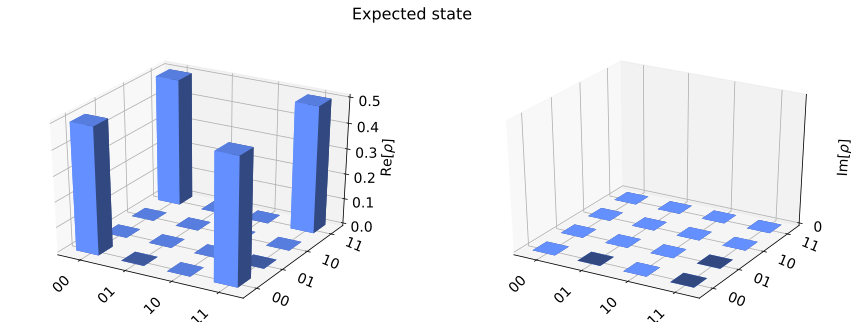

In [3]:
job = qiskit.execute(qc_expected, Aer.get_backend('statevector_simulator'))
psi_expected = job.result().get_statevector(qc_expected)
print('The expected state is:', psi_expected)
plot_state_city(psi_expected, title='Expected state')

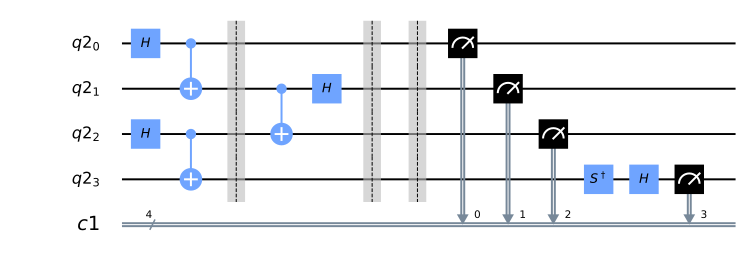

In [4]:
qr = QuantumRegister(4)
cr= ClassicalRegister(4)
qc1 = QuantumCircuit(qr)
qc1.h(0)
qc1.h(2)
qc1.cx(0,1)
qc1.cx(2,3)
qc1.barrier()
qc1.cx(1,2)
qc1.h(1)
qc1.barrier()
qcz=state_tomography_circuits(qc1,[qr])
qct=[qcz[24],qcz[25],qcz[26],qcz[51],qcz[52],qcz[53],qcz[78],qcz[79],qcz[80]]
qct[7].draw(output='mpl')

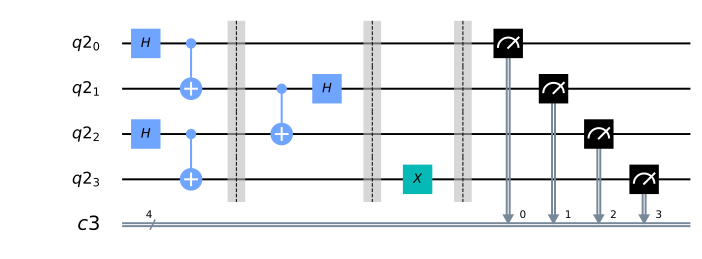

In [5]:
qc2 = QuantumCircuit(qr)
qc3 = QuantumCircuit(qr)
qc4 = QuantumCircuit(qr)
qcs = [qct,qc2,qc3,qc4]
for qc in range(3):
    q2 = QuantumCircuit(qr)
    if qc == 0 or qc == 2:
        q2.z(3)
    if qc == 1 or qc == 2:
        q2.x(3)
    p= qc1 +q2
    q= state_tomography_circuits(p,[qr])
    qcf=[q[24],q[25],q[26],q[51],q[52],q[53],q[78],q[79],q[80]]
    qcs[qc+1] =qcf
qcs[2][8].draw(output='mpl')

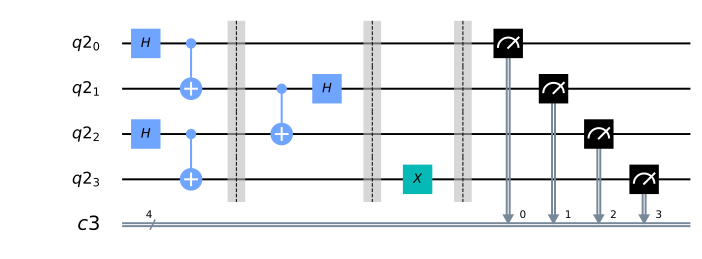

In [6]:
qcs[2][8].draw(output='mpl')

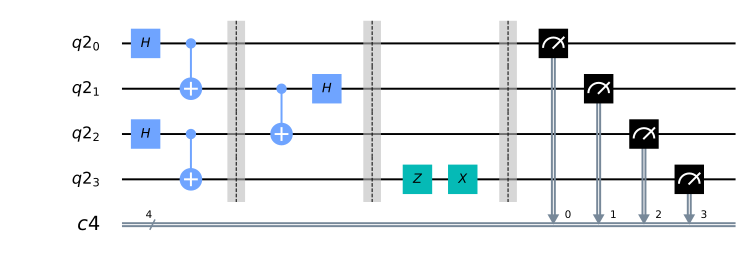

In [7]:
qcs[3][8].draw(output='mpl')

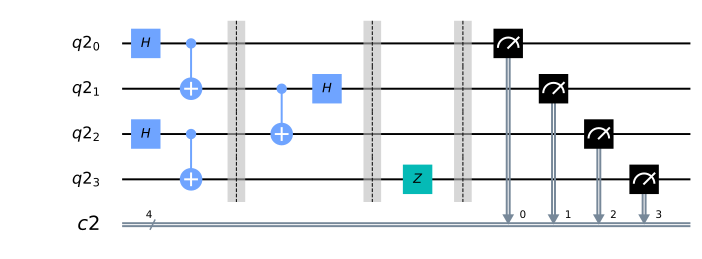

In [8]:
qcs[1][8].draw(output='mpl')

In [9]:
backends = [simulator,device]
measureqbit= [qreg[0],qreg[3]]
bits = [ '1000', '0000', '1110', '1010', '0110', '0010', '1100', '0100','1001', '0001', '1111', '1011', '0111', '0011', '1101', '0101']
paulis = [('X','Z','Z','X'),('X','Z','Z','Y'),('X','Z','Z','Z'),
          ('Y','Z','Z','X'),('Y','Z','Z','Y'),('Y','Z','Z','Z'),
          ('Z','Z','Z','X'),('Z','Z','Z','Y'),('Z','Z','Z','Z')]
for be in backends:
    state = {'XX': {'00': 0, '10': 0,'01': 0, '11': 0}, 
             'YX': {'00': 0, '10': 0,'01': 0, '11': 0}, 
             'ZX': {'00': 0, '10': 0,'01': 0, '11': 0}, 
             'XY': {'00': 0, '10': 0,'01': 0, '11': 0}, 
             'YY': {'00': 0, '10': 0,'01': 0, '11': 0}, 
             'ZY': {'00': 0, '10': 0,'01': 0, '11': 0}, 
             'XZ': {'00': 0, '10': 0,'01': 0, '11': 0}, 
             'YZ': {'00': 0, '10': 0,'01': 0, '11': 0}, 
             'ZZ': {'00': 0, '10': 0,'01': 0, '11': 0}}
    for qc in qcs:
        qst_circuit = qc #state_tomography_circuits(qc,qreg)
        if be == simulator:
            job = execute(qst_circuit, simulator, shots=1000,noise_model=noise_model, coupling_map=coupling_map, basis_gates=basis_gates)
            print('Done job.')
        if be == device:
            job = execute(qst_circuit, be, shots=1000)
            #job = execute(qst_circuit, simulator, shots=1000,noise_model=noise_model, coupling_map=coupling_map, basis_gates=basis_gates)
            job_monitor(job)
            print('Done job.')
            print(job.error_message())
        tom = StateTomographyFitter(job.result(), qst_circuit)
        if qc == qct:
            for pauli in paulis:
                for bit in bits:
                    if bit not in tom.data[pauli]:
                        tom.data[pauli][bit]=0
            state.update({'XX': {'00': state['XX']['00']+tom.data[('X','Z','Z','X')]['0000'],
                                '10': state['XX']['10']+tom.data[('X','Z','Z','X')]['1000'],
                                '01': state['XX']['01']+tom.data[('X','Z','Z','X')]['0001'],
                                '11': state['XX']['11']+tom.data[('X','Z','Z','X')]['1001']}})
            state.update({'YX': {'00': state['YX']['00']+tom.data[('Y','Z','Z','X')]['0000'],
                                '10': state['YX']['10']+tom.data[('Y','Z','Z','X')]['1000'],
                                '01': state['YX']['01']+tom.data[('Y','Z','Z','X')]['0001'],
                                '11': state['YX']['11']+tom.data[('Y','Z','Z','X')]['1001']}})
            state.update({'ZX': {'00': state['ZX']['00']+tom.data[('Z','Z','Z','X')]['0000'],
                                '10': state['ZX']['10']+tom.data[('Z','Z','Z','X')]['1000'],
                                '01': state['ZX']['01']+tom.data[('Z','Z','Z','X')]['0001'],
                                '11': state['ZX']['11']+tom.data[('Z','Z','Z','X')]['1001']}})
            state.update({'XY': {'00': state['XY']['00']+tom.data[('X','Z','Z','Y')]['0000'],
                                '10': state['XY']['10']+tom.data[('X','Z','Z','Y')]['1000'],
                                '01': state['XY']['01']+tom.data[('X','Z','Z','Y')]['0001'],
                                '11': state['XY']['11']+tom.data[('X','Z','Z','Y')]['1001']}})
            state.update({'YY': {'00': state['YY']['00']+tom.data[('Y','Z','Z','Y')]['0000'],
                                '10': state['YY']['10']+tom.data[('Y','Z','Z','Y')]['1000'],
                                '01': state['YY']['01']+tom.data[('Y','Z','Z','Y')]['0001'],
                                '11': state['YY']['11']+tom.data[('Y','Z','Z','Y')]['1001']}})
            state.update({'ZY': {'00': state['ZY']['00']+tom.data[('Z','Z','Z','Y')]['0000'],
                                '10': state['ZY']['10']+tom.data[('Z','Z','Z','Y')]['1000'],
                                '01': state['ZY']['01']+tom.data[('Z','Z','Z','Y')]['0001'],
                                '11': state['ZY']['11']+tom.data[('Z','Z','Z','Y')]['1001']}})
            state.update({'XZ': {'00': state['XZ']['00']+tom.data[('X','Z','Z','Z')]['0000'],
                                '10': state['XZ']['10']+tom.data[('X','Z','Z','Z')]['1000'],
                                '01': state['XZ']['01']+tom.data[('X','Z','Z','Z')]['0001'],
                                '11': state['XZ']['11']+tom.data[('X','Z','Z','Z')]['1001']}})
            state.update({'YZ': {'00': state['YZ']['00']+tom.data[('Y','Z','Z','Z')]['0000'],
                                '10': state['YZ']['10']+tom.data[('Y','Z','Z','Z')]['1000'],
                                '01': state['YZ']['01']+tom.data[('Y','Z','Z','Z')]['0001'],
                                '11': state['YZ']['11']+tom.data[('Y','Z','Z','Z')]['1001']}})
            state.update({'ZZ': {'00': state['ZZ']['00']+tom.data[('Z','Z','Z','Z')]['0000'],
                                '10': state['ZZ']['10']+tom.data[('Z','Z','Z','Z')]['1000'],
                                '01': state['ZZ']['01']+tom.data[('Z','Z','Z','Z')]['0001'],
                                '11': state['ZZ']['11']+tom.data[('Z','Z','Z','Z')]['1001']}})
            print(state)
        if qc == qcs[1]:
            for pauli in paulis:
                for bit in bits:
                    if bit not in tom.data[pauli]:
                        tom.data[pauli][bit]=0
            state.update({'XX': {'00': state['XX']['00']+tom.data[('X','Z','Z','X')]['0010'],
                                '10': state['XX']['10']+tom.data[('X','Z','Z','X')]['1010'],
                                '01': state['XX']['01']+tom.data[('X','Z','Z','X')]['0011'],
                                '11': state['XX']['11']+tom.data[('X','Z','Z','X')]['1011']}})
            state.update({'YX': {'00': state['YX']['00']+tom.data[('Y','Z','Z','X')]['0010'],
                                '10': state['YX']['10']+tom.data[('Y','Z','Z','X')]['1010'],
                                '01': state['YX']['01']+tom.data[('Y','Z','Z','X')]['0011'],
                                '11': state['YX']['11']+tom.data[('Y','Z','Z','X')]['1011']}})
            state.update({'ZX': {'00': state['ZX']['00']+tom.data[('Z','Z','Z','X')]['0010'],
                                '10': state['ZX']['10']+tom.data[('Z','Z','Z','X')]['1010'],
                                '01': state['ZX']['01']+tom.data[('Z','Z','Z','X')]['0011'],
                                '11': state['ZX']['11']+tom.data[('Z','Z','Z','X')]['1011']}})
            state.update({'XY': {'00': state['XY']['00']+tom.data[('X','Z','Z','Y')]['0010'],
                                '10': state['XY']['10']+tom.data[('X','Z','Z','Y')]['1010'],
                                '01': state['XY']['01']+tom.data[('X','Z','Z','Y')]['0011'],
                                '11': state['XY']['11']+tom.data[('X','Z','Z','Y')]['1011']}})
            state.update({'YY': {'00': state['YY']['00']+tom.data[('Y','Z','Z','Y')]['0010'],
                                '10': state['YY']['10']+tom.data[('Y','Z','Z','Y')]['1010'],
                                '01': state['YY']['01']+tom.data[('Y','Z','Z','Y')]['0011'],
                                '11': state['YY']['11']+tom.data[('Y','Z','Z','Y')]['1011']}})
            state.update({'ZY': {'00': state['ZY']['00']+tom.data[('Z','Z','Z','Y')]['0010'],
                                '10': state['ZY']['10']+tom.data[('Z','Z','Z','Y')]['1010'],
                                '01': state['ZY']['01']+tom.data[('Z','Z','Z','Y')]['0011'],
                                '11': state['ZY']['11']+tom.data[('Z','Z','Z','Y')]['1011']}})
            state.update({'XZ': {'00': state['XZ']['00']+tom.data[('X','Z','Z','Z')]['0010'],
                                '10': state['XZ']['10']+tom.data[('X','Z','Z','Z')]['1010'],
                                '01': state['XZ']['01']+tom.data[('X','Z','Z','Z')]['0011'],
                                '11': state['XZ']['11']+tom.data[('X','Z','Z','Z')]['1011']}})
            state.update({'YZ': {'00': state['YZ']['00']+tom.data[('Y','Z','Z','Z')]['0010'],
                                '10': state['YZ']['10']+tom.data[('Y','Z','Z','Z')]['1010'],
                                '01': state['YZ']['01']+tom.data[('Y','Z','Z','Z')]['0011'],
                                '11': state['YZ']['11']+tom.data[('Y','Z','Z','Z')]['1011']}})
            state.update({'ZZ': {'00': state['ZZ']['00']+tom.data[('Z','Z','Z','Z')]['0010'],
                                '10': state['ZZ']['10']+tom.data[('Z','Z','Z','Z')]['1010'],
                                '01': state['ZZ']['01']+tom.data[('Z','Z','Z','Z')]['0011'],
                                '11': state['ZZ']['11']+tom.data[('Z','Z','Z','Z')]['1011']}})
            print(state)
        if qc == qcs[2]:
            for pauli in paulis:
                for bit in bits:
                    if bit not in tom.data[pauli]:
                        tom.data[pauli][bit]=0
            state.update({'XX': {'00': state['XX']['00']+tom.data[('X','Z','Z','X')]['0100'],
                                '10': state['XX']['10']+tom.data[('X','Z','Z','X')]['1100'],
                                '01': state['XX']['01']+tom.data[('X','Z','Z','X')]['0101'],
                                '11': state['XX']['11']+tom.data[('X','Z','Z','X')]['1101']}})
            state.update({'YX': {'00': state['YX']['00']+tom.data[('Y','Z','Z','X')]['0100'],
                                '10': state['YX']['10']+tom.data[('Y','Z','Z','X')]['1100'],
                                '01': state['YX']['01']+tom.data[('Y','Z','Z','X')]['0101'],
                                '11': state['YX']['11']+tom.data[('Y','Z','Z','X')]['1101']}})
            state.update({'ZX': {'00': state['ZX']['00']+tom.data[('Z','Z','Z','X')]['0100'],
                                '10': state['ZX']['10']+tom.data[('Z','Z','Z','X')]['1100'],
                                '01': state['ZX']['01']+tom.data[('Z','Z','Z','X')]['0101'],
                                '11': state['ZX']['11']+tom.data[('Z','Z','Z','X')]['1101']}})
            state.update({'XY': {'00': state['XY']['00']+tom.data[('X','Z','Z','Y')]['0100'],
                                '10': state['XY']['10']+tom.data[('X','Z','Z','Y')]['1100'],
                                '01': state['XY']['01']+tom.data[('X','Z','Z','Y')]['0101'],
                                '11': state['XY']['11']+tom.data[('X','Z','Z','Y')]['1101']}})
            state.update({'YY': {'00': state['YY']['00']+tom.data[('Y','Z','Z','Y')]['0100'],
                                '10': state['YY']['10']+tom.data[('Y','Z','Z','Y')]['1100'],
                                '01': state['YY']['01']+tom.data[('Y','Z','Z','Y')]['0101'],
                                '11': state['YY']['11']+tom.data[('Y','Z','Z','Y')]['1101']}})
            state.update({'ZY': {'00': state['ZY']['00']+tom.data[('Z','Z','Z','Y')]['0100'],
                                '10': state['ZY']['10']+tom.data[('Z','Z','Z','Y')]['1100'],
                                '01': state['ZY']['01']+tom.data[('Z','Z','Z','Y')]['0101'],
                                '11': state['ZY']['11']+tom.data[('Z','Z','Z','Y')]['1101']}})
            state.update({'XZ': {'00': state['XZ']['00']+tom.data[('X','Z','Z','Z')]['0100'],
                                '10': state['XZ']['10']+tom.data[('X','Z','Z','Z')]['1100'],
                                '01': state['XZ']['01']+tom.data[('X','Z','Z','Z')]['0101'],
                                '11': state['XZ']['11']+tom.data[('X','Z','Z','Z')]['1101']}})
            state.update({'YZ': {'00': state['YZ']['00']+tom.data[('Y','Z','Z','Z')]['0100'],
                                '10': state['YZ']['10']+tom.data[('Y','Z','Z','Z')]['1100'],
                                '01': state['YZ']['01']+tom.data[('Y','Z','Z','Z')]['0101'],
                                '11': state['YZ']['11']+tom.data[('Y','Z','Z','Z')]['1101']}})
            state.update({'ZZ': {'00': state['ZZ']['00']+tom.data[('Z','Z','Z','Z')]['0100'],
                                '10': state['ZZ']['10']+tom.data[('Z','Z','Z','Z')]['1100'],
                                '01': state['ZZ']['01']+tom.data[('Z','Z','Z','Z')]['0101'],
                                '11': state['ZZ']['11']+tom.data[('Z','Z','Z','Z')]['1101']}})
            print(state)
        if qc == qcs[3]:
            for pauli in paulis:
                for bit in bits:
                    if bit not in tom.data[pauli]:
                        tom.data[pauli][bit]=0
            state.update({'XX': {'00': state['XX']['00']+tom.data[('X','Z','Z','X')]['0110'],
                                '10': state['XX']['10']+tom.data[('X','Z','Z','X')]['1110'],
                                '01': state['XX']['01']+tom.data[('X','Z','Z','X')]['0111'],
                                '11': state['XX']['11']+tom.data[('X','Z','Z','X')]['1111']}})
            state.update({'YX': {'00': state['YX']['00']+tom.data[('Y','Z','Z','X')]['0110'],
                                '10': state['YX']['10']+tom.data[('Y','Z','Z','X')]['1110'],
                                '01': state['YX']['01']+tom.data[('Y','Z','Z','X')]['0111'],
                                '11': state['YX']['11']+tom.data[('Y','Z','Z','X')]['1111']}})
            state.update({'ZX': {'00': state['ZX']['00']+tom.data[('Z','Z','Z','X')]['0110'],
                                '10': state['ZX']['10']+tom.data[('Z','Z','Z','X')]['1110'],
                                '01': state['ZX']['01']+tom.data[('Z','Z','Z','X')]['0111'],
                                '11': state['ZX']['11']+tom.data[('Z','Z','Z','X')]['1111']}})
            state.update({'XY': {'00': state['XY']['00']+tom.data[('X','Z','Z','Y')]['0110'],
                                '10': state['XY']['10']+tom.data[('X','Z','Z','Y')]['1110'],
                                '01': state['XY']['01']+tom.data[('X','Z','Z','Y')]['0111'],
                                '11': state['XY']['11']+tom.data[('X','Z','Z','Y')]['1111']}})
            state.update({'YY': {'00': state['YY']['00']+tom.data[('Y','Z','Z','Y')]['0110'],
                                '10': state['YY']['10']+tom.data[('Y','Z','Z','Y')]['1110'],
                                '01': state['YY']['01']+tom.data[('Y','Z','Z','Y')]['0111'],
                                '11': state['YY']['11']+tom.data[('Y','Z','Z','Y')]['1111']}})
            state.update({'ZY': {'00': state['ZY']['00']+tom.data[('Z','Z','Z','Y')]['0110'],
                                '10': state['ZY']['10']+tom.data[('Z','Z','Z','Y')]['1110'],
                                '01': state['ZY']['01']+tom.data[('Z','Z','Z','Y')]['0111'],
                                '11': state['ZY']['11']+tom.data[('Z','Z','Z','Y')]['1111']}})
            state.update({'XZ': {'00': state['XZ']['00']+tom.data[('X','Z','Z','Z')]['0110'],
                                '10': state['XZ']['10']+tom.data[('X','Z','Z','Z')]['1110'],
                                '01': state['XZ']['01']+tom.data[('X','Z','Z','Z')]['0111'],
                                '11': state['XZ']['11']+tom.data[('X','Z','Z','Z')]['1111']}})
            state.update({'YZ': {'00': state['YZ']['00']+tom.data[('Y','Z','Z','Z')]['0110'],
                                '10': state['YZ']['10']+tom.data[('Y','Z','Z','Z')]['1110'],
                                '01': state['YZ']['01']+tom.data[('Y','Z','Z','Z')]['0111'],
                                '11': state['YZ']['11']+tom.data[('Y','Z','Z','Z')]['1111']}})
            state.update({'ZZ': {'00': state['ZZ']['00']+tom.data[('Z','Z','Z','Z')]['0110'],
                                '10': state['ZZ']['10']+tom.data[('Z','Z','Z','Z')]['1110'],
                                '01': state['ZZ']['01']+tom.data[('Z','Z','Z','Z')]['0111'],
                                '11': state['ZZ']['11']+tom.data[('Z','Z','Z','Z')]['1111']}})
    if be == simulator:
        state_sim = state
        print('The full state for simulator is', state)
    if be == device:
        state_dev = state
        print('The full state for device is', state)

Done job.
{'XX': {'00': 127, '10': 13, '01': 9, '11': 127}, 'YX': {'00': 60, '10': 58, '01': 66, '11': 53}, 'ZX': {'00': 70, '10': 74, '01': 65, '11': 48}, 'XY': {'00': 69, '10': 79, '01': 83, '11': 59}, 'YY': {'00': 19, '10': 122, '01': 124, '11': 14}, 'ZY': {'00': 72, '10': 78, '01': 59, '11': 60}, 'XZ': {'00': 72, '10': 59, '01': 61, '11': 68}, 'YZ': {'00': 71, '10': 74, '01': 60, '11': 43}, 'ZZ': {'00': 139, '10': 7, '01': 6, '11': 117}}
Done job.
{'XX': {'00': 247, '10': 23, '01': 17, '11': 240}, 'YX': {'00': 142, '10': 125, '01': 120, '11': 116}, 'ZX': {'00': 136, '10': 145, '01': 127, '11': 119}, 'XY': {'00': 132, '10': 132, '01': 139, '11': 113}, 'YY': {'00': 30, '10': 237, '01': 249, '11': 23}, 'ZY': {'00': 147, '10': 152, '01': 116, '11': 128}, 'XZ': {'00': 143, '10': 112, '01': 136, '11': 128}, 'YZ': {'00': 136, '10': 140, '01': 126, '11': 102}, 'ZZ': {'00': 254, '10': 23, '01': 19, '11': 216}}
Done job.
{'XX': {'00': 379, '10': 35, '01': 30, '11': 351}, 'YX': {'00': 211, '1

In [10]:
# fidelity processing for sim and dev
zero = np.matrix('0,0;0,0')
#Iden = np.matrix('1,0;0,1')
XPaul = np.matrix('0,1;1,0')
YPaul = np.matrix('0,0-1j;0+1j,0')
ZPaul = np.matrix('1,0;0,-1')
XXPaul = np.matrix('0,0,0,1;0,0,1,0;0,1,0,0;1,0,0,0')
XYPaul = np.matrix('0,0,0,0-1j;0,0,0+1j,0;0,0-1j,0,0;0+1j,0,0,0')
XZPaul = np.matrix('0,0,1,0;0,0,0,-1;1,0,0,0;0,-1,0,0')

Iden = np.matrix('1,0,0,0;0,1,0,0;0,0,1,0;0,0,0,1')

YXPaul = np.matrix('0,0,0,0-1j;0,0,0-1j,0;0,0+1j,0,0;0+1j,0,0,0')
YYPaul = np.matrix('0,0,0,-1;0,0,1,0;0,1,0,0;-1,0,0,0')
YZPaul = np.matrix('0,0,0-1j,0;0,0,0,0+1j;0+1j,0,0,0;0,0-1j,0,0')

ZXPaul = np.matrix('0,1,0,0;1,0,0,0;0,0,0,-1;0,0,-1,0')
ZYPaul = np.matrix('0,0-1j,0,0;0+1j,0,0,0;0,0,0,0+1j;0,0,0-1j,0')
ZZPaul = np.matrix('1,0,0,0;0,-1,0,0;0,0,-1,0;0,0,0,1')

# simulator Bloch vector
rxx_sim = (state_sim['XX']['00']*1 + state_sim['XX']['10']*(-1)+state_sim['XX']['01']*(-1)+state_sim['XX']['11']*1) /(state_sim['XX']['00']*1 + state_sim['XX']['10']*(1)+state_sim['XX']['01']*(1)+state_sim['XX']['11']*1)
rxy_sim = (state_sim['XY']['00']*1 + state_sim['XY']['10']*(-1)+state_sim['XY']['01']*(-1)+state_sim['XY']['11']*1) /(state_sim['XY']['00']*1 + state_sim['XY']['10']*(1)+state_sim['XY']['01']*(1)+state_sim['XY']['11']*1)
rxz_sim = (state_sim['XZ']['00']*1 + state_sim['XZ']['10']*(-1)+state_sim['XZ']['01']*(-1)+state_sim['XZ']['11']*1) /(state_sim['XZ']['00']*1 + state_sim['XZ']['10']*(1)+state_sim['XZ']['01']*(1)+state_sim['XZ']['11']*1)
ryx_sim = (state_sim['YX']['00']*1 + state_sim['YX']['10']*(-1)+state_sim['YX']['01']*(-1)+state_sim['YX']['11']*1) /(state_sim['YX']['00']*1 + state_sim['YX']['10']*(1)+state_sim['YX']['01']*(1)+state_sim['YX']['11']*1)
ryy_sim = (state_sim['YY']['00']*1 + state_sim['YY']['10']*(-1)+state_sim['YY']['01']*(-1)+state_sim['YY']['11']*1) /(state_sim['YY']['00']*1 + state_sim['YY']['10']*(1)+state_sim['YY']['01']*(1)+state_sim['YY']['11']*1)
ryz_sim = (state_sim['YZ']['00']*1 + state_sim['YZ']['10']*(-1)+state_sim['YZ']['01']*(-1)+state_sim['YZ']['11']*1) /(state_sim['YZ']['00']*1 + state_sim['YZ']['10']*(1)+state_sim['YZ']['01']*(1)+state_sim['YZ']['11']*1)
rzx_sim = (state_sim['ZX']['00']*1 + state_sim['ZX']['10']*(-1)+state_sim['ZX']['01']*(-1)+state_sim['ZX']['11']*1) /(state_sim['ZX']['00']*1 + state_sim['ZX']['10']*(1)+state_sim['ZX']['01']*(1)+state_sim['ZX']['11']*1)
rzy_sim = (state_sim['ZY']['00']*1 + state_sim['ZY']['10']*(-1)+state_sim['ZY']['01']*(-1)+state_sim['ZY']['11']*1) /(state_sim['ZY']['00']*1 + state_sim['ZY']['10']*(1)+state_sim['ZY']['01']*(1)+state_sim['ZY']['11']*1)
rzz_sim = (state_sim['ZZ']['00']*1 + state_sim['ZZ']['10']*(-1)+state_sim['ZZ']['01']*(-1)+state_sim['ZZ']['11']*1) /(state_sim['ZZ']['00']*1 + state_sim['ZZ']['10']*(1)+state_sim['ZZ']['01']*(1)+state_sim['ZZ']['11']*1)

rho_sim = (1/4)*(Iden+rxx_sim*XXPaul+rxy_sim*XYPaul+rxz_sim*XZPaul+
                 ryx_sim*YXPaul+ryy_sim*YYPaul+ryz_sim*YZPaul+
                rzx_sim*ZXPaul+rzy_sim*ZYPaul+rzz_sim*ZZPaul)

rxx_dev = (state_dev['XX']['00']*1 + state_dev['XX']['10']*(-1)+state_dev['XX']['01']*(-1)+state_dev['XX']['11']*1) /(state_dev['XX']['00']*1 + state_dev['XX']['10']*(1)+state_dev['XX']['01']*(1)+state_dev['XX']['11']*1)
rxy_dev = (state_dev['XY']['00']*1 + state_dev['XY']['10']*(-1)+state_dev['XY']['01']*(-1)+state_dev['XY']['11']*1) /(state_dev['XY']['00']*1 + state_dev['XY']['10']*(1)+state_dev['XY']['01']*(1)+state_dev['XY']['11']*1)
rxz_dev = (state_dev['XZ']['00']*1 + state_dev['XZ']['10']*(-1)+state_dev['XZ']['01']*(-1)+state_dev['XZ']['11']*1) /(state_dev['XZ']['00']*1 + state_dev['XZ']['10']*(1)+state_dev['XZ']['01']*(1)+state_dev['XZ']['11']*1)
ryx_dev = (state_dev['YX']['00']*1 + state_dev['YX']['10']*(-1)+state_dev['YX']['01']*(-1)+state_dev['YX']['11']*1) /(state_dev['YX']['00']*1 + state_dev['YX']['10']*(1)+state_dev['YX']['01']*(1)+state_dev['YX']['11']*1)
ryy_dev = (state_dev['YY']['00']*1 + state_dev['YY']['10']*(-1)+state_dev['YY']['01']*(-1)+state_dev['YY']['11']*1) /(state_dev['YY']['00']*1 + state_dev['YY']['10']*(1)+state_dev['YY']['01']*(1)+state_dev['YY']['11']*1)
ryz_dev = (state_dev['YZ']['00']*1 + state_dev['YZ']['10']*(-1)+state_dev['YZ']['01']*(-1)+state_dev['YZ']['11']*1) /(state_dev['YZ']['00']*1 + state_dev['YZ']['10']*(1)+state_dev['YZ']['01']*(1)+state_dev['YZ']['11']*1)
rzx_dev = (state_dev['ZX']['00']*1 + state_dev['ZX']['10']*(-1)+state_dev['ZX']['01']*(-1)+state_dev['ZX']['11']*1) /(state_dev['ZX']['00']*1 + state_dev['ZX']['10']*(1)+state_dev['ZX']['01']*(1)+state_dev['ZX']['11']*1)
rzy_dev = (state_dev['ZY']['00']*1 + state_dev['ZY']['10']*(-1)+state_dev['ZY']['01']*(-1)+state_dev['ZY']['11']*1) /(state_dev['ZY']['00']*1 + state_dev['ZY']['10']*(1)+state_dev['ZY']['01']*(1)+state_dev['ZY']['11']*1)
rzz_dev = (state_dev['ZZ']['00']*1 + state_dev['ZZ']['10']*(-1)+state_dev['ZZ']['01']*(-1)+state_dev['ZZ']['11']*1) /(state_dev['ZZ']['00']*1 + state_dev['ZZ']['10']*(1)+state_dev['ZZ']['01']*(1)+state_dev['ZZ']['11']*1)

rho_dev = (1/4)*(Iden+rxx_dev*XXPaul+rxy_dev*XYPaul+rxz_dev*XZPaul+
                 ryx_dev*YXPaul+ryy_dev*YYPaul+ryz_dev*YZPaul+
                rzx_dev*ZXPaul+rzy_dev*ZYPaul+rzz_dev*ZZPaul)

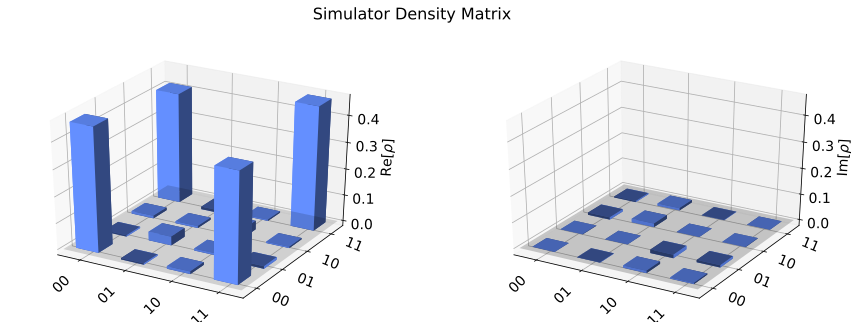

In [11]:
plot_state_city(rho_sim, title='Simulator Density Matrix')

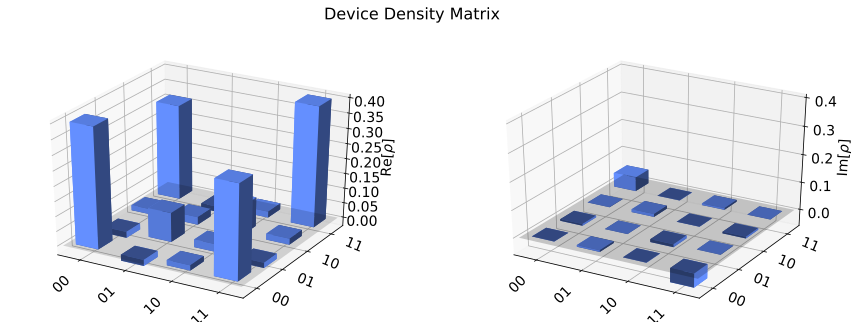

In [12]:
plot_state_city(rho_dev, title='Device Density Matrix')

In [13]:
Sim_Fidelity = state_fidelity(psi_expected, rho_sim, validate=False)
Dev_Fidelity = state_fidelity(psi_expected, rho_dev, validate=False)
print('Simulator Fidelity:', Sim_Fidelity)
print('Device Fidelity:', Dev_Fidelity)

Simulator Fidelity: 0.8818746482002013
Device Fidelity: 0.7186474483349493
